In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
style.use('notebook.mplstyle')

In [6]:
from scipy import integrate
import emcee, corner
import gwb

In [7]:
tgas = gwb.TGASData('../data/stacked_tgas.fits')

In [7]:
def like_distance(d, p, sigp):
    """likelihood of distance given parallax and its error
    d : distance
    p : parallax
    sigp : parallax error
    """
    return 1./sqrt(2*pi)/sigp * exp(-0.5/sigp**2 * (p-1./d)**2)

def prior_distance_uniform(d, rlim=1e3):
    """truncated uniform prior"""
    if d>0 and d<rlim:
        return 1./rlim
    return 0.

def prior_distance_constdens(d, rlim=1e3):
    """costant volume density prior on distance"""
    if d>0 and d<rlim:
        return 3./rlim**3 * d**2
    return 0.

def prior_distance_expcutoff(d, L=1e3):
    """constant density + exponential cut-off
    
    L : length scale"""
    if d>0:
        return 1./(2.*L**3) * d**2 * exp(-d/L)
    return 0.

def post_distance(d, p, sigp, prior=prior_distance_uniform, normalize=False):
    """posterior of ditance
    """
    if normalize:
        integrand = lambda d: like_distance(d, p, sigp)* prior(d)
        Z = integrate.quad(integrand, 0, inf)[0]
        return like_distance(d, p, sigp)*prior(d)/Z
    if prior(d)>0:
        return like_distance(d, p, sigp)*prior(d)
    return 0.

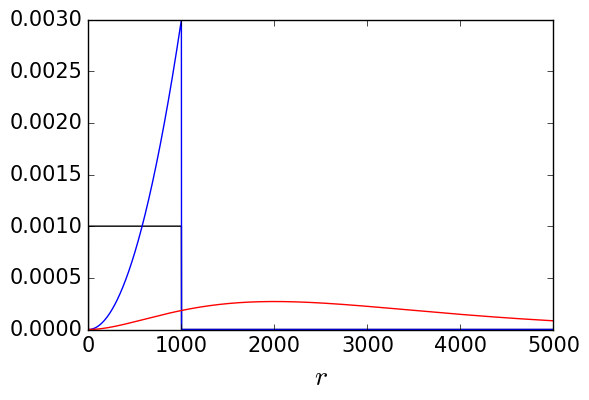

In [328]:
r = linspace(0,5000, 10000)
plot(r, [prior_distance_uniform(rr) for rr in r], 'k-')
plot(r, [prior_distance_constdens(rr) for rr in r], 'b-')
plot(r, [prior_distance_expcutoff(rr) for rr in r], 'r-')
xlabel('$r$')

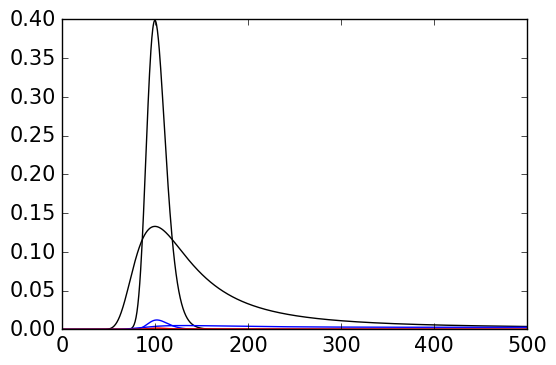

In [8]:
r = linspace(0.1, 500, 1000)
for p, sigp in ([0.01, 0.001], [0.01, 0.003]):
    plot(r, [post_distance(rr, p, sigp, prior=prior_distance_uniform) for rr in r], 'k-')
    plot(r, [post_distance(rr, p, sigp, prior=prior_distance_constdens) for rr in r], 'b-')
    plot(r, [post_distance(rr, p, sigp, prior=prior_distance_expcutoff) for rr in r], 'r-')

In [9]:
def likelihood_gaussian(X, D, C):
    # gaussian likelihood at X given Data and Covariance matrix
    # X, D : 1-d array of size ndim
    # C : 2-d array of shape ndim, ndim
    ndim = X.size
    assert X.shape == D.shape, 'X and D must have the same shape'
    assert C.shape[0] == ndim, 'covariance matrix for %i must be %i, %i' % (ndim, ndim, ndim)
    R = D-X
    invC = inv(C)
    return float(sqrt(det(invC)/ (2.*pi)**ndim) * exp(-0.5 * R[newaxis].dot(invC).dot(R[newaxis].T)))

In [10]:
def prior_velocity_gaussian(v_ra, v_dec, sigv=30.):
    # isotropic velocity dispersion
    return 1./(2.*pi*sigv**2) * exp(-0.5*(v_ra**2+v_dec**2)/sigv**2)

In [48]:
def likelihood(d1, d2, v_ra, v_dec, p1, p2, sigp1, sigp2, mu1, mu2, C1, C2):
    # mu: [pmra, pmdec]
    # v: [v_ra, v_dec]
    # d1,d2 : scalars
    v = array([v_ra, v_dec])
    Pmu1 = likelihood_gaussian(v/d1/4.74, mu1, C1)
    Pmu2 = likelihood_gaussian(v/d2/4.74, mu1, C2)
    Pd1 = post_distance(d1, p1, sigp1)
    Pd2 = post_distance(d2, p2, sigp2)
    Pv = prior_velocity_gaussian(v_ra, v_dec)
    return Pmu1*Pmu2*Pd1*Pd2

def likelihood_null(d1, d2, v1_ra, v1_dec, v2_ra, v2_dec, p1, p2, sigp1, sigp2, mu1, mu2, C1, C2):
    # mu: [pmra, pmdec]
    # v: [v_ra, v_dec]
    # d1,d2 : scalars
    v1 = array([v1_ra, v1_dec])
    Pmu1 = likelihood_gaussian(v1/d1/4.74, mu1, C1)
    v2 = array([v2_ra, v2_dec])
    Pmu2 = likelihood_gaussian(v2/d2/4.74, mu2, C2)
    Pd1 = post_distance(d1, p1, sigp1, prior=prior_distance_expcutoff)
    Pd2 = post_distance(d2, p2, sigp2, prior=prior_distance_expcutoff)
    Pv1 = prior_velocity_gaussian(v1_ra, v1_dec)
    Pv2 = prior_velocity_gaussian(v2_ra, v2_dec)
    return Pmu1*Pmu2*Pv1*Pv2*Pd1*Pd2

# Identical star

In [151]:
C = array([[0.01, 0], [0, 0.01]])

p1 = 0.1
sigp1 = 0.01
mu1 = array([1., 0])

p2 = 0.1
sigp2 = 0.01
mu2 = array([1, 0.])

ndim = 4
def lnprob(x, *args):
    return log(likelihood(x[0], x[1], x[2], x[3],
                          p1, p1, sigp1, sigp1, mu1, mu1, C, C))
nwalkers=10

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnprob,
    )

p0 = vstack([random.normal(1./p1, 1./p1*sigp1/p1, nwalkers),
             random.normal(1./p2, 1./p2*sigp1/p2, nwalkers),
             random.normal(0, 30., nwalkers),
             random.normal(0, 30., nwalkers)]).T


sampler.reset()
pos, prob, state = sampler.run_mcmc(p0, 1000)

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

/Users/semyeong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


[ 0.86528262  0.95479687  4.81005049  3.45642681]
0.0996833512955


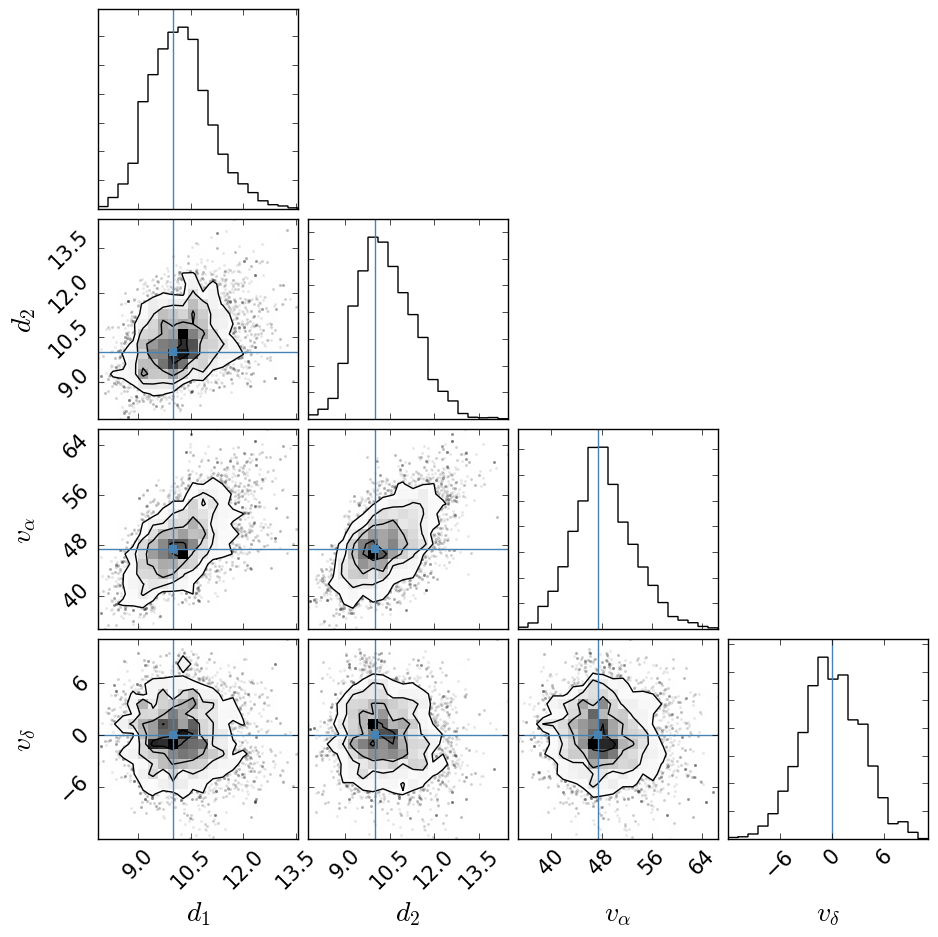

In [152]:
print std(samples, axis=0)
print mean([likelihood(x[0],x[1],x[2],x[3], p1, p1, sigp1, sigp1, mu1, mu1, C, C) for x in samples])
fig = corner.corner(
    samples,
    labels=['$d_1$', '$d_2$', r'$v_\alpha$', r'$v_\delta$'],
    truths=[1./p1, 1./p1, mu1[0]/p1*4.74, mu1[1]/p1*4.74])

In [159]:
C = array([[0.01, 0], [0, 0.01]])

p1 = 0.1
sigp1 = 0.01
mu1 = array([1., 0])

p2 = 0.01
sigp2 = 0.001
mu2 = array([0, 1.])

ndim = 4
def lnprob(x, *args):
    return log(likelihood(x[0], x[1], x[2], x[3],
                          p1, p1, sigp1, sigp1, mu1, mu1, C, C))
nwalkers=10

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnprob,
    )

p0 = vstack([random.normal(1./p1, 1./p1*sigp1/p1, nwalkers),
             random.normal(1./p2, 1./p2*sigp2/p2, nwalkers),
             random.normal(0, 30., nwalkers),
             random.normal(0, 30., nwalkers)]).T


sampler.reset()
pos, prob, state = sampler.run_mcmc(p0, 1000)

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

/Users/semyeong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


[ 1.59390493  1.50451283  7.04741677  3.57612396]
3.63909221005e-116


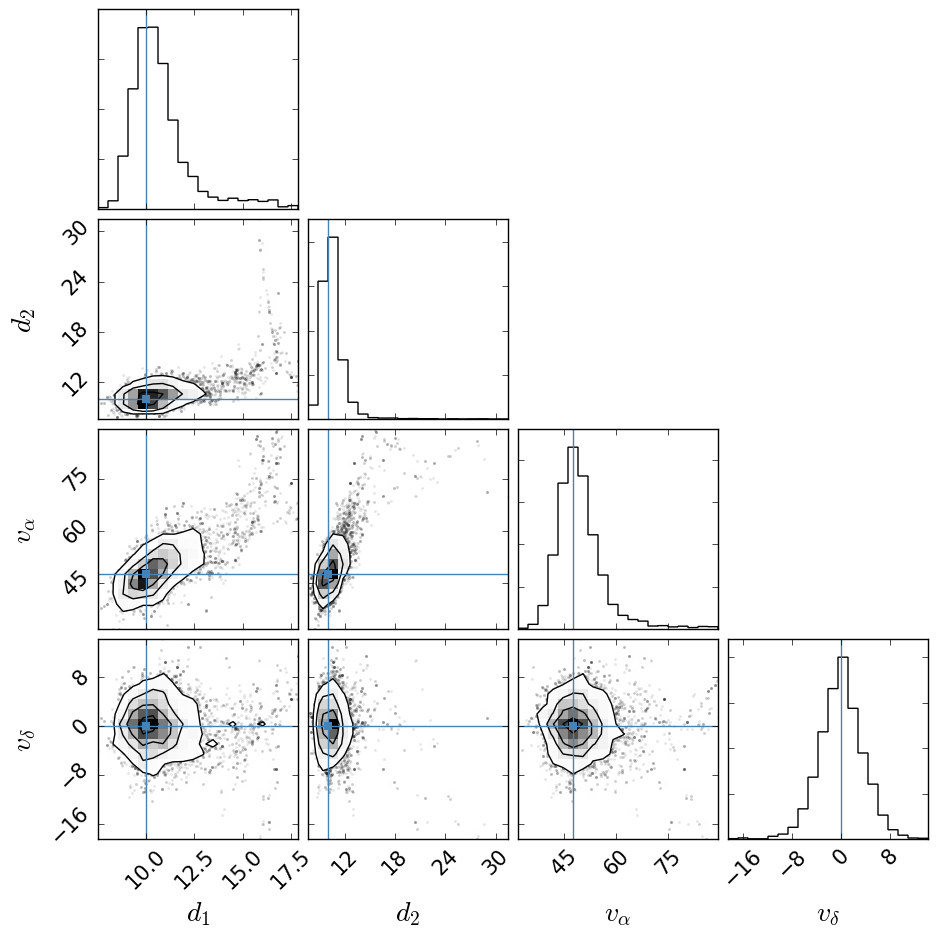

In [160]:
print std(samples, axis=0)
print mean([likelihood(x[0],x[1],x[2],x[3], p1, p2, sigp1, sigp2, mu1, mu2, C, C) for x in samples])
fig = corner.corner(
    samples,
    labels=['$d_1$', '$d_2$', r'$v_\alpha$', r'$v_\delta$'],
    truths=[1./p1, 1./p1, mu1[0]/p1*4.74, mu1[1]/p1*4.74])